In [264]:

import tensorflow as tf
from keras.layers import Dense, MultiHeadAttention, LayerNormalization,Input,Dropout,LSTM
import keras
from keras import layers
from tensorflow.keras.models import Model,Sequential
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from IPython.display import clear_output
from utils import *
%matplotlib inline
test_percent = .1

MAX_SEQ_LENGTH = 50  # Maximum sequence length for padding/truncating sequences
EMBEDDING_DIM = 32   # Embedding dimension for input sequences
NUM_HEADS = 4        # Number of attention heads in the multi-head attention layer
NUM_ENCODER_LAYERS = 2  # Number of encoder layers in the transformer
NUM_DECODER_LAYERS = 2  # Number of decoder layers in the transformer
DROPOUT_RATE = 0.1   # Dropout rate for regularization
LEARNING_RATE = 1e-4

In [265]:
class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)
        if len(metrics) == 1:
            axs = [axs]
        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

In [266]:
def transformer_model_prime(input_shape, num_heads, ff_dim, num_blocks, dropout_rate):
    inputs = keras.Input(shape=input_shape)

    x = inputs
    for _ in range(num_blocks):
        # Multi-head self-attention
        x1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=input_shape[1], dropout=dropout_rate
        )(x, x)
        x1 = layers.Dropout(dropout_rate)(x1)
        x1 = layers.LayerNormalization(epsilon=1e-6)(x + x1)

        # Feed-forward neural network
        x2 = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x1)
        x2 = layers.Dropout(dropout_rate)(x2)
        x2 = layers.Conv1D(filters=input_shape[1], kernel_size=1)(x2)
        x2 = layers.LayerNormalization(epsilon=1e-6)(x1 + x2)

        x = x2

    # Global average pooling and dense layers
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(32, activation="relu")(x)
    outputs = layers.Dense(1, activation="linear")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [267]:
def encoder_layer(inputs, d_model, num_heads, dropout_rate, name="encoder_layer"):
    """
    Single encoder layer in the transformer model.
    """
    # Multi-head self-attention
    attn_output = tf.keras.layers.MultiHeadAttention(
        key_dim=d_model, num_heads=num_heads, dropout=dropout_rate, name=name + "_multihead_attention"
    )(inputs, inputs)

    # Add and normalize
    attn_output = tf.keras.layers.LayerNormalization(epsilon=1e-6, name=name + "_ln1")(inputs + attn_output)

    # Feed-forward part
    ff_output = tf.keras.layers.Dense(units=d_model, activation="relu", name=name + "_ffn")(attn_output)

    # Add and normalize
    ff_output = tf.keras.layers.LayerNormalization(epsilon=1e-6, name=name + "_ln2")(attn_output + ff_output)

    return ff_output


def encoder(inputs, d_model, num_heads, num_layers, dropout_rate):
    """
    Encoder stack of the transformer model.
    """
    outputs = inputs
    for i in range(num_layers):
        outputs = encoder_layer(outputs, d_model, num_heads, dropout_rate, name="encoder_layer_{}".format(i))

    return outputs


def decoder_layer(inputs, enc_outputs, d_model, num_heads, dropout_rate, name="decoder_layer"):
    """
    Single decoder layer in the transformer model.
    """
    # Multi-head self-attention (masked)
    attn_output1 = tf.keras.layers.MultiHeadAttention(
        key_dim=d_model, num_heads=num_heads, dropout=dropout_rate, name=name + "_masked_multihead_attention"
    )(inputs, inputs, attention_mask=tf.linalg.band_part(tf.ones((MAX_SEQ_LENGTH, MAX_SEQ_LENGTH)), -1, 0))

    # Add and normalize
    attn_output1 = tf.keras.layers.LayerNormalization(epsilon=1e-6, name=name + "_ln1")(inputs + attn_output1)

    # Multi-head attention over encoder outputs
    attn_output2 = tf.keras.layers.MultiHeadAttention(
        key_dim=d_model, num_heads=num_heads, dropout=dropout_rate, name=name + "_enc_dec_attention"
    )(attn_output1, enc_outputs)

    # Add and normalize
    attn_output2 = tf.keras.layers.LayerNormalization(epsilon=1e-6, name=name + "_ln2")(attn_output1 + attn_output2)

    # Feed-forward part
    ff_output = tf.keras.layers.Dense(units=d_model, activation="relu", name=name + "_ffn")(attn_output2)

    # Add and normalize
    ff_output = tf.keras.layers.LayerNormalization(epsilon=1e-6, name=name + "_ln3")(attn_output2 + ff_output)

    return ff_output


def decoder(inputs, enc_outputs, d_model, num_heads, num_layers, dropout_rate):
    """
    Decoder stack of the transformer model.
    """
    outputs = inputs
    for i in range(num_layers):
        outputs = decoder_layer(outputs, enc_outputs, d_model, num_heads, dropout_rate, name="decoder_layer_{}".format(i))

    return outputs

def transformer_model(d_model, num_heads, num_encoder_layers, num_decoder_layers, dropout_rate, max_seq_length):
    """
    Complete transformer model for stock price forecasting.

    """
    # Encoder inputs
    encoder_inputs = Input(shape=(max_seq_length, d_model), name="encoder_inputs")

    # Encoder
    enc_outputs = encoder(encoder_inputs, d_model, num_heads, num_encoder_layers, dropout_rate)

    # Decoder inputs
    decoder_inputs = Input(shape=(max_seq_length, d_model), name="decoder_inputs")

    # Decoder
    dec_outputs = decoder(decoder_inputs, enc_outputs, d_model, num_heads, num_decoder_layers, dropout_rate)

    # Final dense layer to predict stock prices
    outputs = Dense(units=1, activation="linear", name="output_layer")(dec_outputs)

    # Create the model
    model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=outputs)

    return model


In [268]:
def buildLSTM(Inshape):
    model = Sequential()
    model.add(LSTM(units=50,return_sequences=True,input_shape=Inshape))
    model.add(Dropout(0.2))

    model.add(LSTM(units=50,return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(units=50,return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(units=50))
    model.add(Dropout(0.2))

    model.add(Dense(units=1))
    return model

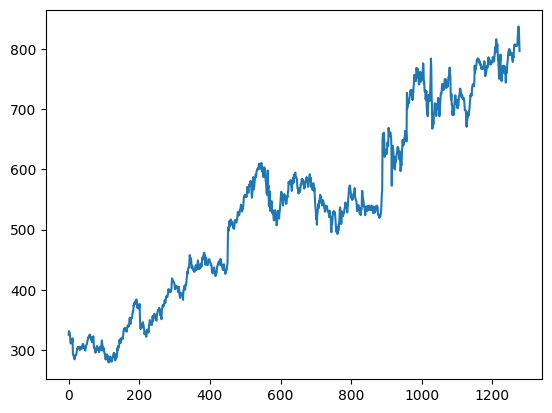

In [269]:
df = pd.read_csv("NVidia_stock_history.csv")

train_df = pd.read_csv("Google_Stock_Price_Train.csv")
test_df = pd.read_csv("Google_Stock_Price_Test.csv")
df = pd.concat([train_df,test_df],axis=0,ignore_index=True)

data = df.loc[:,'Open'].values.reshape(-1,1)


plt.plot(data)


In [271]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

input_sequences, target_sequences = create_sequences(scaled_data, MAX_SEQ_LENGTH)


In [272]:
split_index = int((1-test_percent) * len(input_sequences))

train_input = input_sequences[:split_index]
train_target = target_sequences[:split_index]
test_input = input_sequences[split_index:]
test_target = target_sequences[split_index:]

In [273]:
# # Create the transformer model
# model = transformer_model(
#     d_model=EMBEDDING_DIM,
#     num_heads=NUM_HEADS,
#     num_encoder_layers=NUM_ENCODER_LAYERS,
#     num_decoder_layers=NUM_DECODER_LAYERS,
#     dropout_rate=DROPOUT_RATE,
#     max_seq_length=MAX_SEQ_LENGTH
# )

# model.compile(optimizer="adam", loss="mse")
# model.fit(train_input, train_target, batch_size=8, epochs=10, validation_split=0.2)

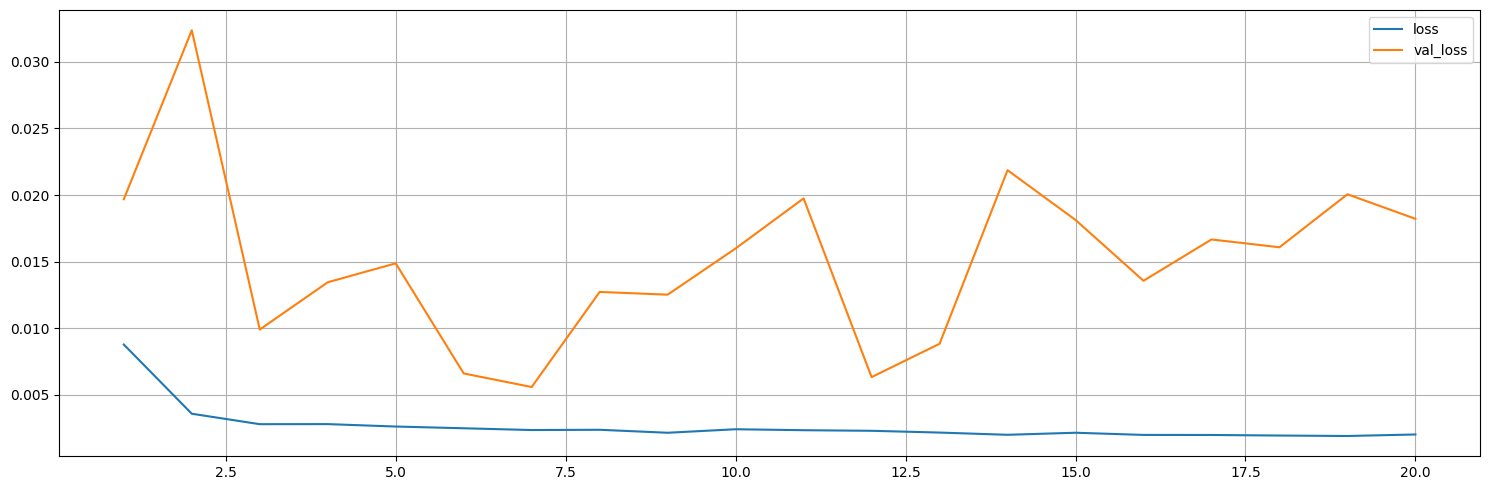

111/111 [==============================] - 3s 24ms/step - loss: 0.0020 - val_loss: 0.0182


In [288]:
callback_list = [PlotLearning()]
# num_heads = 2  # Number of attention heads
# ff_dim = 32  # Hidden layer size in feed-forward network inside transformer
# num_blocks = 4  # Number of transformer blocks
# dropout_rate = 0.2

# # Create the transformer model
# model = transformer_model_prime((train_target.shape[1],train_target.shape[2]), num_heads, ff_dim, num_blocks, dropout_rate)
model = buildLSTM((train_target.shape[1],train_target.shape[2]))

# Compile the model
model.compile(optimizer="adam", loss="mse")

model.fit(train_input, train_target, batch_size=8, epochs=20, validation_split=0.2,callbacks=callback_list)

In [289]:
predicted_stock_price = model.predict(test_input)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
actual_stock_price = data[split_index:]
# predicted_stock_price

4/4 [==============================] - 1s 8ms/step


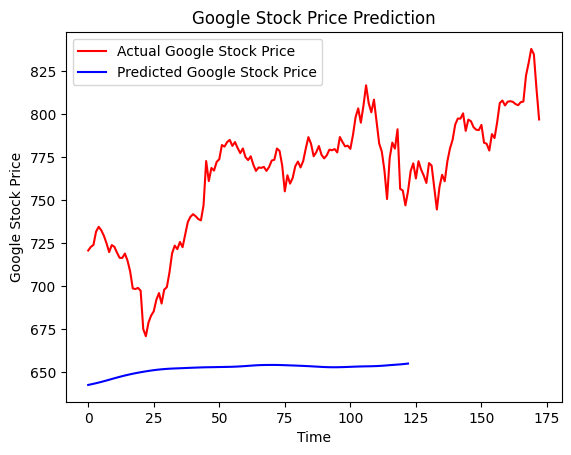

In [290]:
plt.plot(actual_stock_price,color = 'red',label='Actual Google Stock Price')
plt.plot(predicted_stock_price,color = 'blue',label='Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()

In [291]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
import math

diff = actual_stock_price-predicted_stock_price

plt.axhline(y=0,color='black',linestyle='--')
plt.plot(diff,color = 'red')

mse = mean_squared_error(actual_stock_price, predicted_stock_price)
mae = mean_absolute_error(actual_stock_price, predicted_stock_price)
print(f"RMSE = {math.sqrt(mse)}")
print(f'MAE  = {mae}')

ValueError: operands could not be broadcast together with shapes (173,1) (123,1) 